# Progetto su Time Series
A cura di:
- Marco Michellini 207429
- Matteo Battilori 207260
- Christian von Waldorff 208420

In [1]:
import os
os.chdir('/Users/chris/Notes/masters/BigDataAnalytics/Lab/AssignmentEDA')
#!kaggle datasets download rohanrao/formula-1-world-championship-1950-2020!unzip formula-1-world-championship-1950-2020.zip

Archive:  formula-1-world-championship-1950-2020.zip
  inflating: circuits.csv            
  inflating: constructor_results.csv  
  inflating: constructor_standings.csv  
  inflating: constructors.csv        
  inflating: driver_standings.csv    
  inflating: drivers.csv             
  inflating: lap_times.csv           
  inflating: pit_stops.csv           
  inflating: qualifying.csv          
  inflating: races.csv               
  inflating: results.csv             
  inflating: seasons.csv             
  inflating: sprint_results.csv      
  inflating: status.csv              


### Importazione delle librerie necessarie per l'analisi 

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats 
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor


Importiamo i dati in pandas e creiamo i rispettici DF per poterli manipolare

In [2]:
df_circuits = pd.read_csv('circuits.csv', na_values=['\\N'])
df_constructors = pd.read_csv('constructors.csv', na_values=['\\N'])
df_drivers = pd.read_csv('drivers.csv', na_values=['\\N'])
df_races = pd.read_csv('races.csv', na_values=['\\N'])
df_results = pd.read_csv('results.csv', na_values=['\\N'])
df_status = pd.read_csv('status.csv', na_values=['\\N'])

## Rimozione colonne irrilevanti per l'analisi

In [3]:
df_circuits.drop(['alt', 'url', 'lat', 'lng', 'circuitRef'], axis=1, inplace=True)
df_constructors.drop(['url', 'constructorRef'], axis=1, inplace=True)
df_drivers.drop(['url', 'driverRef', 'number', 'code'], axis=1, inplace=True)
df_races.drop(['url', 'name', 'time', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'], axis=1, inplace=True)
df_results.drop(['time', 'number', 'position', 'positionOrder', 'rank', 'fastestLap', 'fastestLapSpeed', 'fastestLapTime'], axis=1, inplace=True)

df_circuits.rename(columns={'name': 'circuit_name', 'location': 'circuit_location', 'country': 'circuit_country'}, inplace=True)
df_constructors.rename(columns={'name': 'constructor_name', 'nationality': 'constructor_nationality'}, inplace=True)
df_drivers.rename(columns={'nationality': 'driver_nationality'}, inplace=True)
df_results.rename(columns={'grid': 'starting_position', 'positionText': 'final_position', 'milliseconds': 'finishing_time'}, inplace=True)

df_results['finishing_time'] = df_results['finishing_time'] / 1000
df_results.loc[df_results['raceId'] == 918, 'points'] = df_results.loc[df_results['raceId'] == 918, 'points'] / 2

## Unione dei Data Frame

*   I singoli DataFrame (`df_results`, `df_races`, `df_circuits`, `df_drivers`, `df_constructors`, `df_status`) sono stati uniti in un unico DataFrame `df` completo.
*   L'unione è stata eseguita utilizzando `pd.merge` con un `how='inner'`, il che significa che verranno conservate solo le righe per cui esiste una corrispondenza nelle colonne di join in *tutti* i DataFrame coinvolti. Le colonne chiave per le unioni sono `raceId`, `circuitId`, `driverId`, `constructorId`, e `statusId`.
*   Questo passaggio è fondamentale per creare una vista integrata dei dati, combinando informazioni sui risultati delle gare, i circuiti, i piloti, i costruttori e lo stato di completamento della gara.

Al termine di questi passaggi, il DataFrame `df` contiene una visione consolidata e pulita dei dati, pronta per le fasi successive di analisi esplorativa e modellazione.



In [4]:
df = pd.merge(df_results, df_races, on='raceId', how='inner')

df = pd.merge(df, df_circuits, on='circuitId', how='inner')

df = pd.merge(df, df_drivers, on='driverId', how='inner')

df = pd.merge(df, df_constructors, on='constructorId', how='inner')

df = pd.merge(df, df_status, on='statusId', how='inner')

In [6]:
print('Stampiamo informazioni sul dataframe creato:\n')
df.info()

Stampiamo informazioni sul dataframe creato:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   resultId                 26759 non-null  int64  
 1   raceId                   26759 non-null  int64  
 2   driverId                 26759 non-null  int64  
 3   constructorId            26759 non-null  int64  
 4   starting_position        26759 non-null  int64  
 5   final_position           26759 non-null  object 
 6   points                   26759 non-null  float64
 7   laps                     26759 non-null  int64  
 8   finishing_time           7680 non-null   float64
 9   statusId                 26759 non-null  int64  
 10  year                     26759 non-null  int64  
 11  round                    26759 non-null  int64  
 12  circuitId                26759 non-null  int64  
 13  date                     26759

In [29]:
df.head()

,resultId,raceId,driverId,constructorId,starting_position,final_position,points,laps,finishing_time,statusId,...,circuit_name,circuit_location,circuit_country,forename,surname,dob,driver_nationality,constructor_name,constructor_nationality,status
0,1,18,1,1,1,1,10.0,58,5690.616,1,...,Albert Park Grand Prix Circuit,Melbourne,Australia,Lewis,Hamilton,1985-01-07,British,McLaren,British,Finished
1,2,18,2,2,5,2,8.0,58,5696.094,1,...,Albert Park Grand Prix Circuit,Melbourne,Australia,Nick,Heidfeld,1977-05-10,German,BMW Sauber,German,Finished
2,3,18,3,3,7,3,6.0,58,5698.779,1,...,Albert Park Grand Prix Circuit,Melbourne,Australia,Nico,Rosberg,1985-06-27,German,Williams,British,Finished
3,4,18,4,4,11,4,5.0,58,5707.797,1,...,Albert Park Grand Prix Circuit,Melbourne,Australia,Fernando,Alonso,1981-07-29,Spanish,Renault,French,Finished
4,5,18,5,1,3,5,4.0,58,5708.630,1,...,Albert Park Grand Prix Circuit,Melbourne,Australia,Heikki,Kovalainen,1981-10-19,Finnish,McLaren,British,Finished


In [5]:
df.describe()

,resultId,raceId,driverId,constructorId,starting_position,points,laps,finishing_time,statusId,year,round,circuitId
count,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,7680.000000,26759.000000,26759.000000,26759.000000,26759.000000
mean,13380.977391,551.687283,278.673530,50.180537,11.134796,1.987632,46.301768,6185.832953,17.224971,1991.394372,8.511192,23.820808
std,7726.134642,313.265036,282.703039,61.551498,7.202860,4.351209,29.496557,1669.306489,26.026104,19.952885,5.070231,19.112002
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.526000,1.000000,1950.000000,1.000000,1.000000
25%,6690.500000,300.000000,57.000000,6.000000,5.000000,0.000000,23.000000,5378.454500,1.000000,1977.000000,4.000000,9.000000
50%,13380.000000,531.000000,172.000000,25.000000,11.000000,0.000000,53.000000,5788.193500,10.000000,1991.000000,8.000000,18.000000
75%,20069.500000,811.000000,399.500000,63.000000,17.000000,2.000000,66.000000,6402.676000,14.000000,2009.000000,12.000000,34.000000
max,26764.000000,1144.000000,862.000000,215.000000,34.000000,50.000000,200.000000,15090.540000,141.000000,2024.000000,24.000000,80.000000


In [10]:
df.isna().sum()
print("I valori nulli in corrispondenza del finishing_time sono relativi a piloti che non hanno terminato la gara\n\
evento comune nelle gare di F1")

I valori nulli in corrispondenza del finishing_time sono relativi a piloti che non hanno terminato la gara
evento comune nelle gare di F1



---

<br>

## Grafici Esplorativi

Riportiamo grafici informativi per le colonne che compongono il dataframe per osservare la distribuzione dei dati 

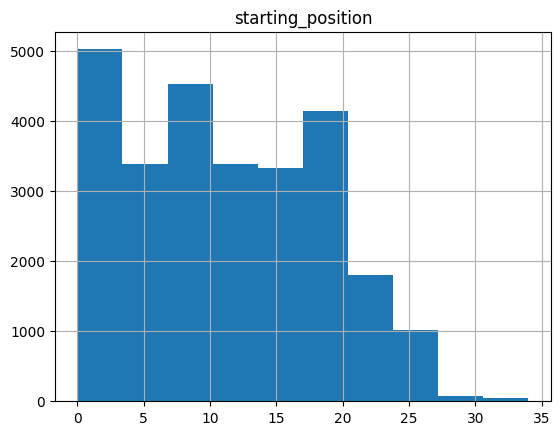

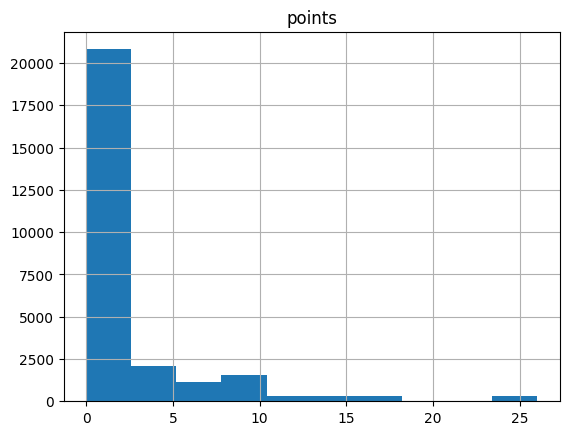

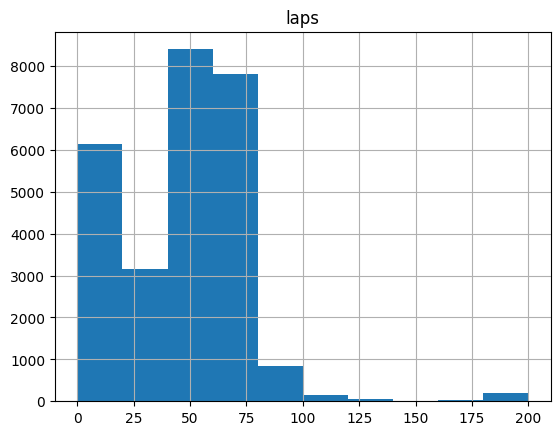

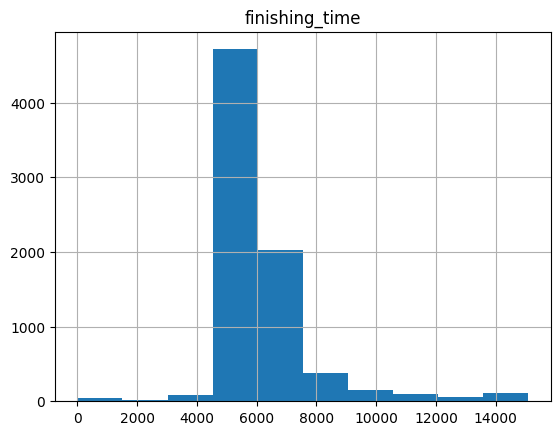

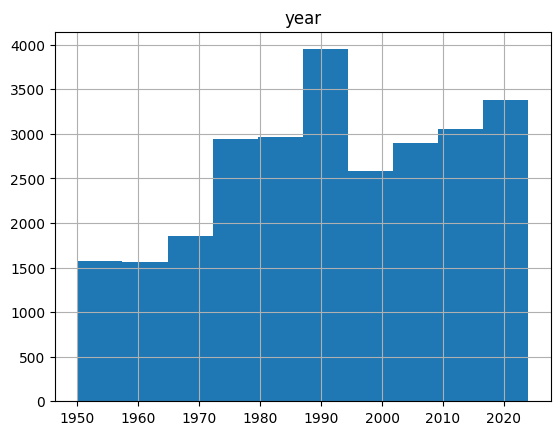

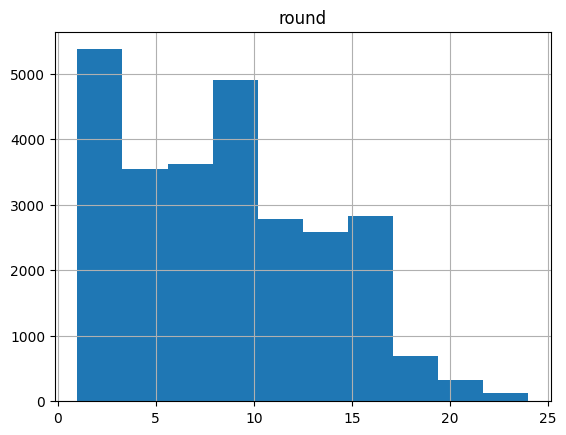

In [52]:
num_columns = ["starting_position", "points", "laps", "finishing_time", "year", "round"]
obj_columns = ["final_position", "date", "circuit_name", "circuit_location", "circuit_country", "forename", "surname", "driver_nationality", "constructor_name", "constructor_nationality", "status", "dob"]

for column in num_columns:
    df[column].hist()
    plt.title(column)
    plt.show()

Per i dati numerici calcoliamo:
- Mediana e Range Interquartile (IQR)

Per i dati qualitativi calcoliamo:
- Moda

In [8]:
for col in num_columns:
  print(f'Feature {col}: median {df[col].median()}, IQR: [{df[col].quantile(0.25)},{df[col].quantile(0.75)}]')

for col in obj_columns:
  print(f'Feature {col}: mode {df[col].mode()[0]}')

Feature starting_position: median 11.0, IQR: [5.0,17.0]
Feature points: median 0.0, IQR: [0.0,2.0]
Feature laps: median 53.0, IQR: [23.0,66.0]
Feature finishing_time: median 5788.193499999999, IQR: [5378.4545,6402.676]
Feature year: median 1991.0, IQR: [1977.0,2009.0]
Feature round: median 8.0, IQR: [4.0,12.0]
Feature final_position: mode R
Feature date: mode 1954-05-31
Feature circuit_name: mode Autodromo Nazionale di Monza
Feature circuit_location: mode Monza
Feature circuit_country: mode Italy
Feature forename: mode Carlos
Feature surname: mode Schumacher
Feature driver_nationality: mode British
Feature constructor_name: mode Ferrari
Feature constructor_nationality: mode British
Feature status: mode Finished
Feature dob: mode 1981-07-29


In [19]:
df.head(5)

,resultId,raceId,driverId,constructorId,starting_position,final_position,points,laps,finishing_time,statusId,...,circuit_name,circuit_location,circuit_country,forename,surname,dob,driver_nationality,constructor_name,constructor_nationality,status
0,1,18,1,1,1,1,10.0,58,5690.616,1,...,Albert Park Grand Prix Circuit,Melbourne,Australia,Lewis,Hamilton,1985-01-07,British,McLaren,British,Finished
1,2,18,2,2,5,2,8.0,58,5696.094,1,...,Albert Park Grand Prix Circuit,Melbourne,Australia,Nick,Heidfeld,1977-05-10,German,BMW Sauber,German,Finished
2,3,18,3,3,7,3,6.0,58,5698.779,1,...,Albert Park Grand Prix Circuit,Melbourne,Australia,Nico,Rosberg,1985-06-27,German,Williams,British,Finished
3,4,18,4,4,11,4,5.0,58,5707.797,1,...,Albert Park Grand Prix Circuit,Melbourne,Australia,Fernando,Alonso,1981-07-29,Spanish,Renault,French,Finished
4,5,18,5,1,3,5,4.0,58,5708.630,1,...,Albert Park Grand Prix Circuit,Melbourne,Australia,Heikki,Kovalainen,1981-10-19,Finnish,McLaren,British,Finished


## Analisi Esplorativa dei Dati (EDA) - Grafici Descrittivi Iniziali

Dopo aver preparato e unito i dati, iniziamo una fase di analisi esplorativa (EDA) per comprendere meglio le caratteristiche principali del dataset. Utilizzeremo grafici a barre per visualizzare le frequenze di alcune variabili chiave. Ogni riga del nostro DataFrame `df` rappresenta il risultato di un singolo pilota in una singola gara.

Il seguente grafico mostra le posizioni finali più comuni per i piloti  
La prima barra (quella più alta) indica che 'R' $\rightarrow$ Ritirato è l'esito più frequente in F1, e conta oltre 8500 occorrenze.  



<Figure size 1500x500 with 0 Axes>

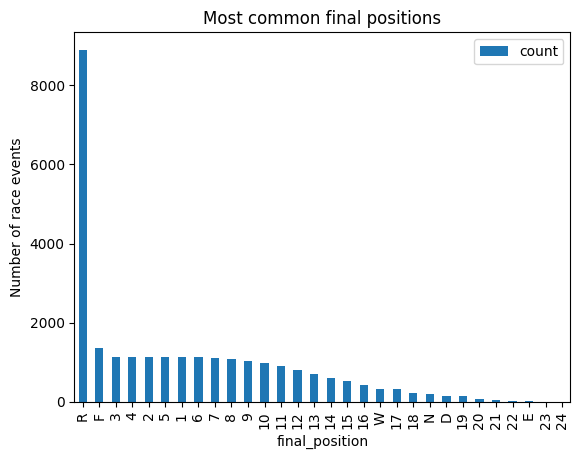

In [13]:
m = df["final_position"].value_counts().reset_index().head(30)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="final_position",y="count")
plt.ylabel("Number of race events")
plt.title("Most common final positions")
plt.show()

Il seguente grafico mostra le date in cui c'è stato il maggior numero di partecipazioni di piloti, si noti che le prime 30 date sono relative a gare vecchie dove il numero di piloti partecipanti era superiore al numero di partecipanti delle gare moderne

<Figure size 1500x500 with 0 Axes>

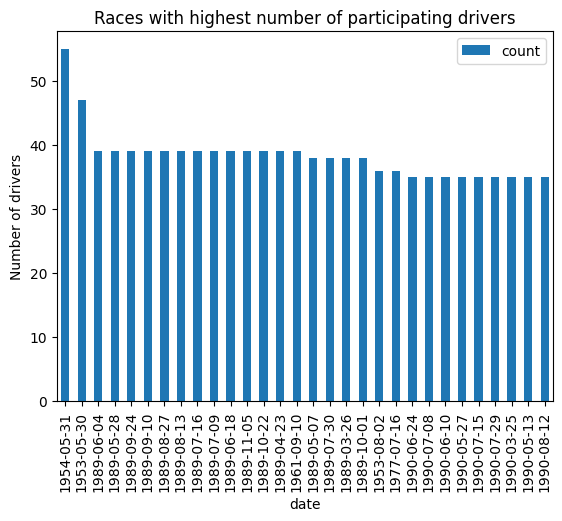

In [27]:
m = df["date"].value_counts().reset_index().head(30)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="date",y="count")
plt.ylabel("Number of drivers")
plt.title("Races with highest number of participating drivers")
plt.show()

Il seguente grafico mostra quali circuiti hanno ospitato il maggior volume di attività di gara in termini di partecipazioni totali

<Figure size 1500x500 with 0 Axes>

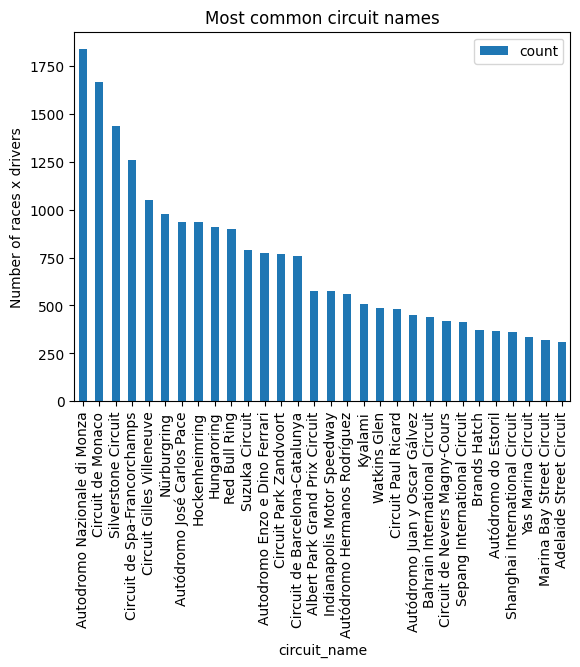

In [15]:
m = df["circuit_name"].value_counts().reset_index().head(30)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="circuit_name",y="count")
plt.ylabel("Number of races x drivers")
plt.title("Most common circuit names")
plt.show()

In termini di location 

<Figure size 1500x500 with 0 Axes>

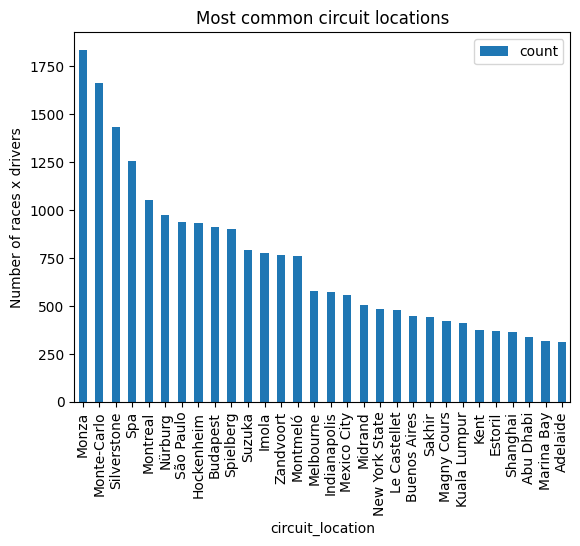

In [16]:
m = df["circuit_location"].value_counts().reset_index().head(30)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="circuit_location",y="count")
plt.ylabel("Number of races x drivers")
plt.title("Most common circuit locations")
plt.show()

In termini di paesi ospitanti dei circuiti 

<Figure size 1500x500 with 0 Axes>

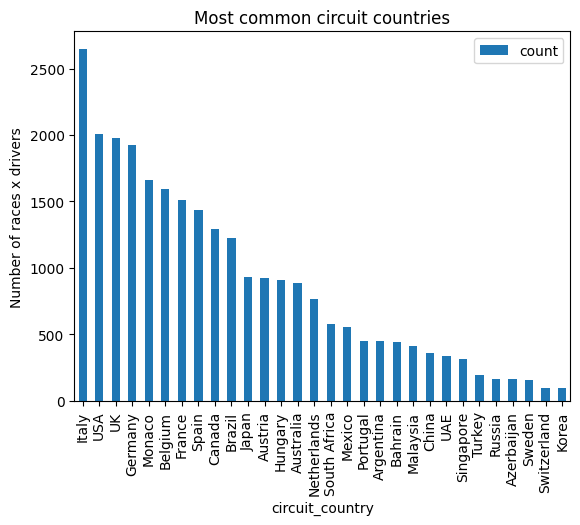

In [17]:
m = df["circuit_country"].value_counts().reset_index().head(30)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="circuit_country",y="count")
plt.ylabel("Number of races x drivers")
plt.title("Most common circuit countries")
plt.show()

Il grafico mostra la frequenza dei 30 nomi più comuni tra piloti che hanno gareggiato in F1

<Figure size 1500x500 with 0 Axes>

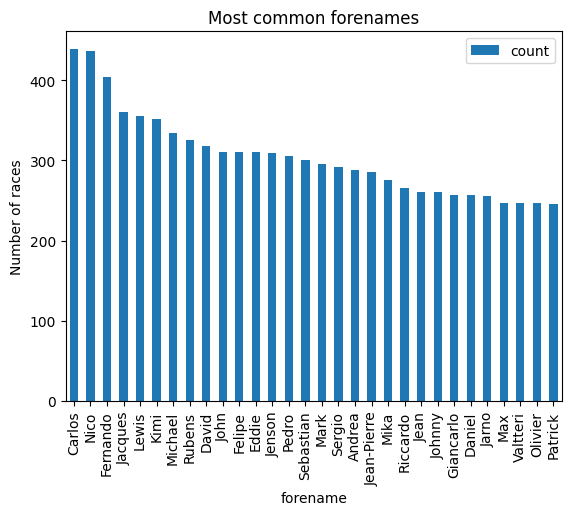

In [18]:
m = df["forename"].value_counts().reset_index().head(30)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="forename",y="count")
plt.ylabel("Number of races")
plt.title("Most common forenames")
plt.show()

<Figure size 1500x500 with 0 Axes>

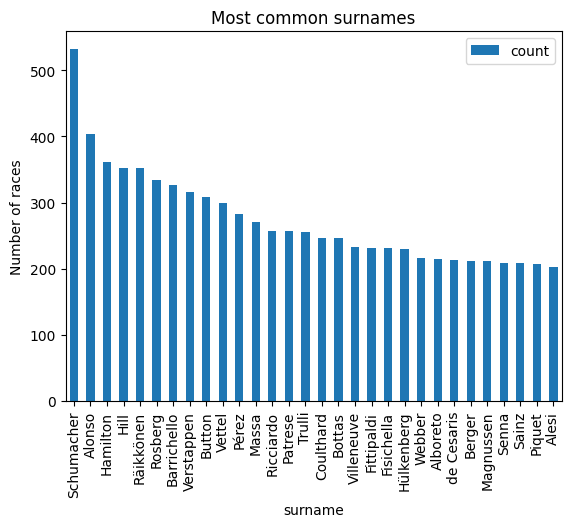

In [19]:
m = df["surname"].value_counts().reset_index().head(30)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="surname",y="count")
plt.ylabel("Number of races")
plt.title("Most common surnames")
plt.show()

Nazionalità più ricorrenti dei piloti partecipanti 

<Figure size 1500x500 with 0 Axes>

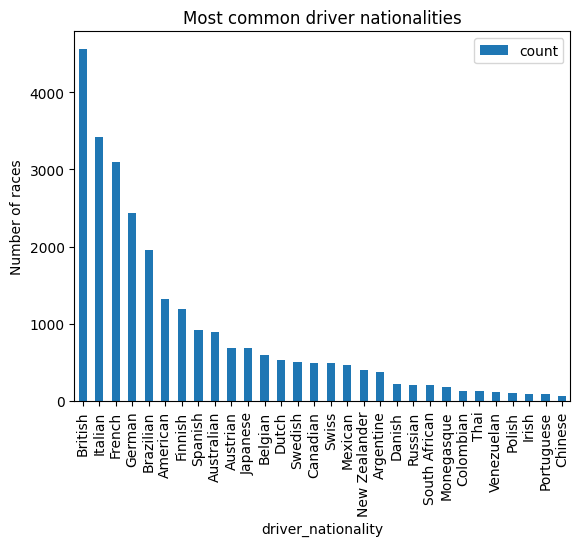

In [20]:
m = df["driver_nationality"].value_counts().reset_index().head(30)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="driver_nationality",y="count")
plt.ylabel("Number of races")
plt.title("Most common driver nationalities")
plt.show()

Costruttori di macchine F1 che hanno avuto il maggior numero di partecipazioni 

<Figure size 1500x500 with 0 Axes>

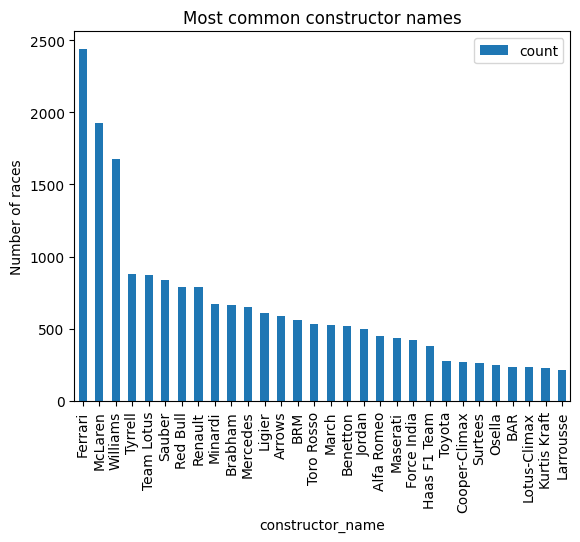

In [21]:
m = df["constructor_name"].value_counts().reset_index().head(30)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="constructor_name",y="count")
plt.ylabel("Number of races")
plt.title("Most common constructor names")
plt.show()

<Figure size 1500x500 with 0 Axes>

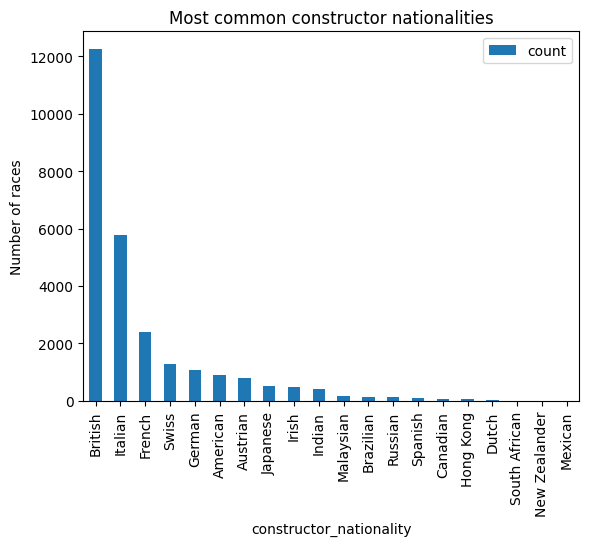

In [22]:
m = df["constructor_nationality"].value_counts().reset_index().head(20)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="constructor_nationality",y="count")
plt.ylabel("Number of races")
plt.title("Most common constructor nationalities")
plt.show()

<Figure size 1500x500 with 0 Axes>

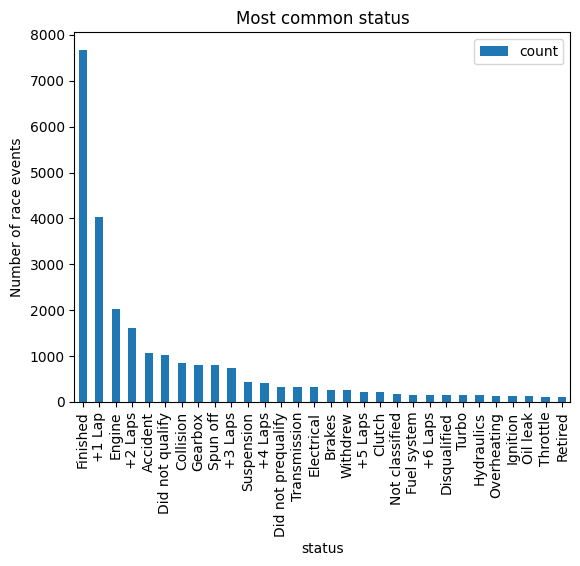

In [23]:
m = df["status"].value_counts().reset_index().head(30)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="status",y="count")
plt.ylabel("Number of race events")
plt.title("Most common status")
plt.show()

<Figure size 1500x500 with 0 Axes>

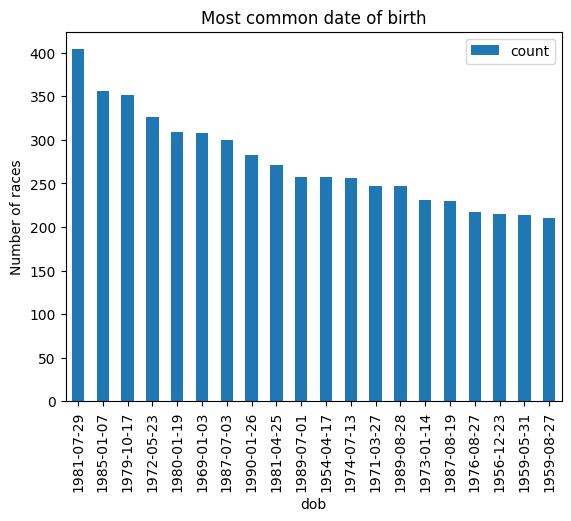

In [24]:
m = df["dob"].value_counts().reset_index().head(20)
plt.figure(figsize=(15,5))
m.plot(kind='bar',x="dob",y="count")
plt.ylabel("Number of races")
plt.title("Most common date of birth")
plt.show()

## Analisi delle Performance nel Tempo: Top 5 Nazionalità dei Piloti e Costruttori (dal 2000)

Proseguiamo l'analisi esplorativa concentrandoci sulle tendenze temporali a partire dall'anno 2000. Vogliamo visualizzare quali sono state le nazionalità dei piloti più rappresentate anno per anno. Per fare ciò, identificheremo dinamicamente le "Top 5" nazionalità per ciascun anno e le visualizzeremo tramite grafici a barre impilati.

**Top 5 Nazionalità dei Piloti per Anno (basato sul Numero di Partecipazioni):**
Il primo grafico mostrerà, per ogni anno dal 2000, le 5 nazionalità dei piloti con il maggior numero di partecipazioni in gara.
- L'**asse X** rappresenta l'anno.
- L'**asse Y** rappresenta il numero totale di "risultati pilota-gara" (cioè, partecipazioni).
- Ogni barra annuale è impilata, con segmenti colorati che indicano il contributo di ciascuna delle 5 nazionalità più frequenti di quell'anno al totale delle partecipazioni delle "top 5".
Questo ci permette di vedere l'evoluzione della diversità e predominanza delle nazionalità nel paddock della Formula 1.


<Figure size 20000x2000 with 0 Axes>

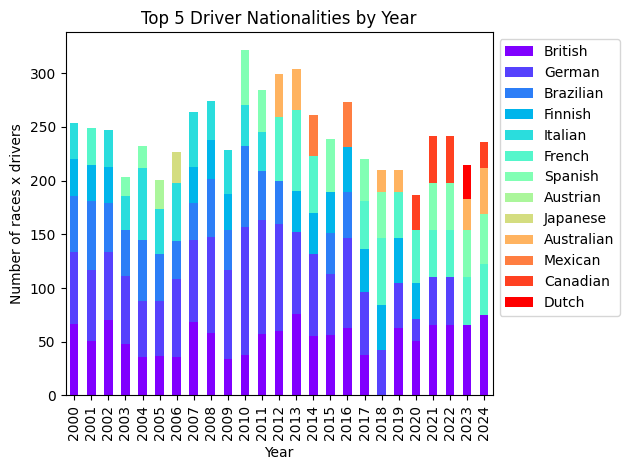

In [32]:
plt.figure(figsize=(200,20))

df_filtered=df.loc[df['year']>=2000]

grouped_data = df_filtered.groupby(["year", "driver_nationality"]).size().unstack(fill_value=0)

top5_per_year = grouped_data.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)

top5_df = top5_per_year.apply(pd.Series)

grouped_data_top5 = pd.DataFrame()

for year in top5_df.index:
    top5_nationalities = top5_df.loc[year].tolist()
    year_data = grouped_data.loc[year, top5_nationalities]
    grouped_data_top5 = pd.concat([grouped_data_top5, year_data.to_frame().T], axis=0)

ax = grouped_data_top5.plot(kind="bar", stacked=True, colormap='rainbow')

plt.xlabel("Year")
plt.ylabel("Number of races x drivers")
plt.title("Top 5 Driver Nationalities by Year")

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## Top 5 Costruttori per Anno (basato sulla Somma dei Punti):
Il secondo grafico mostrerà, per ogni anno dal 2000, i 5 costruttori che hanno accumulato il maggior numero di punti.
- L'**asse X** rappresenta l'anno.
- L'**asse Y** rappresenta la somma totale dei punti conquistati.
- Similmente al grafico precedente, ogni barra annuale è impilata, e i segmenti colorati mostrano i punti ottenuti da ciascuno dei 5 costruttori più performanti di quell'anno.
Questo grafico evidenzia le squadre dominanti in diverse ere e la distribuzione dei successi ai vertici del campionato costruttori.

<Figure size 20000x2000 with 0 Axes>

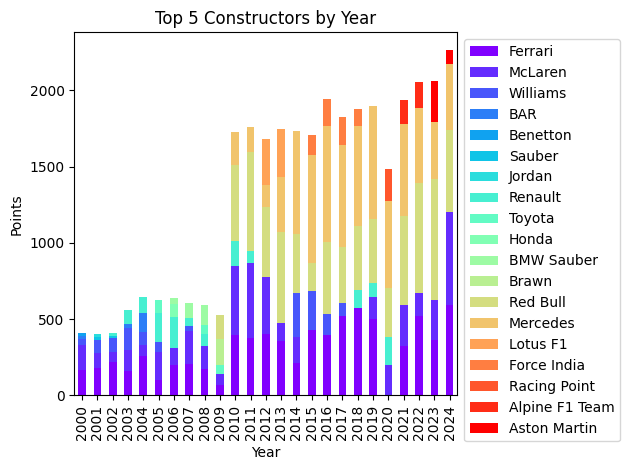

In [58]:
plt.figure(figsize=(200,20))

df_filtered=df.loc[df['year']>=2000]

grouped_data = df_filtered.groupby(["year", "constructor_name"])["points"].sum().unstack(fill_value=0)

top5_per_year = grouped_data.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)

top5_df = top5_per_year.apply(pd.Series)

grouped_data_top5 = pd.DataFrame()

for year in top5_df.index:
    top5_constructors = top5_df.loc[year].tolist()
    year_data = grouped_data.loc[year, top5_constructors]
    grouped_data_top5 = pd.concat([grouped_data_top5, year_data.to_frame().T], axis=0)

ax = grouped_data_top5.plot(kind="bar", stacked=True, colormap='rainbow')

plt.xlabel("Year")
plt.ylabel("Points")
plt.title("Top 5 Constructors by Year")

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## Distribuzione dei Punti per Costruttore (dal 2000)

Per analizzare più a fondo la performance dei singoli costruttori, utilizziamo un box plot. Questo tipo di grafico ci permette di visualizzare la distribuzione dei punti ottenuti da ciascun costruttore in ogni singola gara a cui ha partecipato (dal 2000 in poi), offrendo una visione più completa rispetto a una semplice media.

-   L'**asse X** elenca i nomi dei costruttori.
-   L'**asse Y** rappresenta i punti ottenuti in una singola gara.

Per ogni costruttore, il grafico mostra:
-   La **scatola (box)**: che racchiude il 50% centrale dei risultati a punti.
    -   La **linea interna alla scatola** è la **mediana** (il valore centrale dei punti ottenuti).
-   I **baffi**: che si estendono per mostrare il range dei risultati tipici.
-   I **punti isolati**: che indicano risultati di gara con punteggi insolitamente alti rispetto al comportamento tipico di quel costruttore.

Questa visualizzazione ci aiuta a:
1.  **Confrontare la performance generale**: Costruttori con scatole e mediane più alte tendono a segnare più punti regolarmente.
2.  **Valutare la consistenza**: Scatole più strette indicano una maggiore consistenza nei punteggi ottenuti.
3.  **Identificare risultati eccezionali**: I punti isolati evidenziano gare particolarmente positive (o negative) per un team.
4.  **Distinguere fasce di competitività** tra i team.

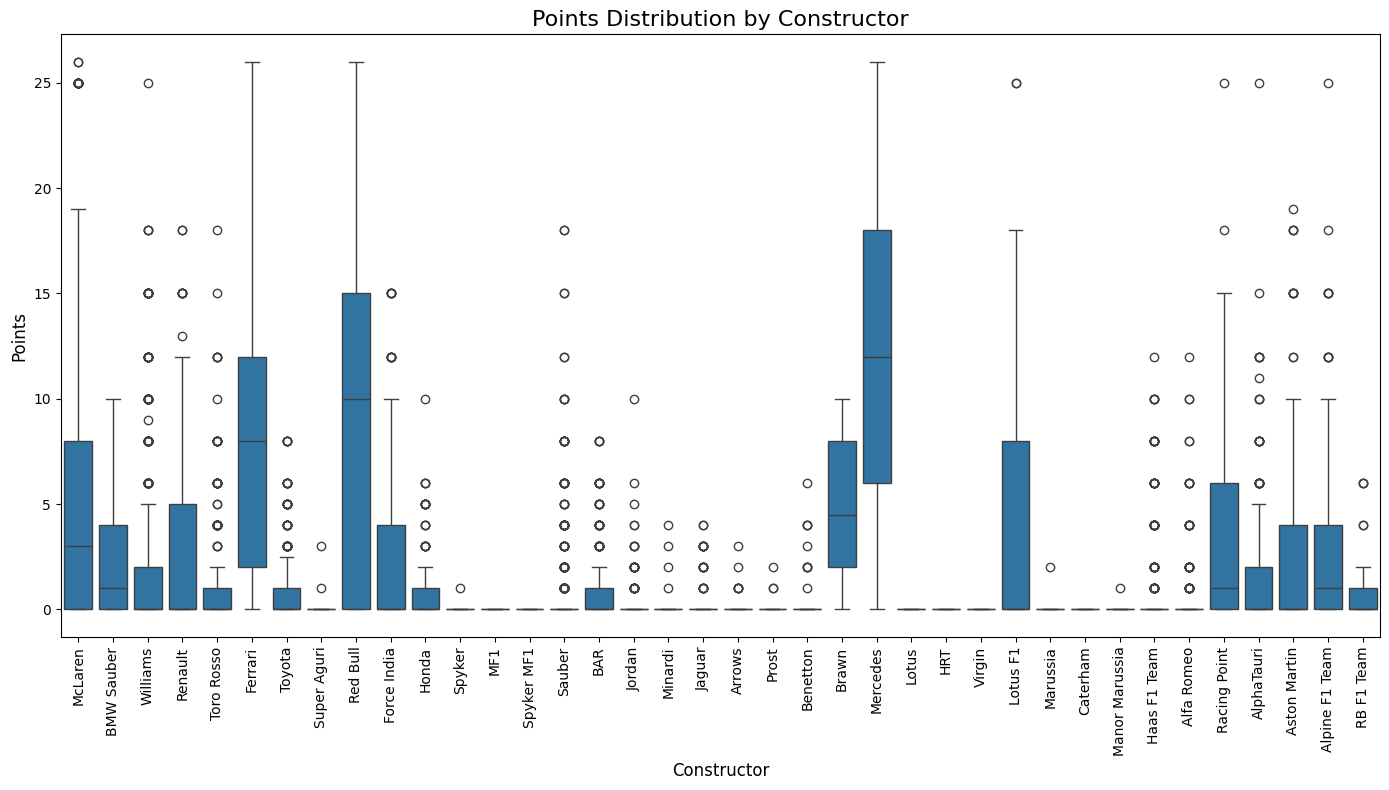

In [35]:
plt.figure(figsize=(14, 8))

ax = sns.boxplot(x='constructor_name', y='points', data=df_filtered)

plt.xticks(rotation=90)

plt.title('Points Distribution by Constructor', fontsize=16)
plt.xlabel('Constructor', fontsize=12)
plt.ylabel('Points', fontsize=12)

plt.tight_layout()

plt.show()

Osservando il grafico possiamo affermare che i costruttori Mercedes, Red Bull e Ferrari tendono a ottenere punteggi più alti per gara in media.

---

<br>

## Distribuzione dei Tempi di Gara per Circuito

Dopo aver analizzato i punti, esaminiamo un'altra metrica fondamentale: la durata delle gare. Utilizziamo un box plot per visualizzare la distribuzione dei tempi di completamento della gara per ciascun circuito presente nel dataset (filtrato dal 2000 in poi).

-   L'**asse X** elenca i nomi dei circuiti.
-   L'**asse Y** rappresenta il tempo di gara totale in secondi.

Ogni box plot ci fornirà informazioni su:
-   **Tempo di gara mediano**: la durata tipica di una corsa su quel circuito.
-   **Variabilità dei tempi**: l'altezza della scatola (IQR) e l'estensione dei baffi indicano quanto i tempi di gara tendono a variare. Circuiti con scatole più alte o baffi più lunghi hanno una maggiore dispersione nei tempi.
-   **Gare anomale**: punti isolati che rappresentano gare con durate significativamente diverse dalla norma per quel circuito, a causa di interruzioni, safety car prolungate o condizioni meteorologiche.

Questa visualizzazione ci permette di confrontare le caratteristiche temporali delle gare sui diversi circuiti, identificando quelli che tendono a produrre gare più lunghe o più corte, e quelli dove la durata è più o meno prevedibile.

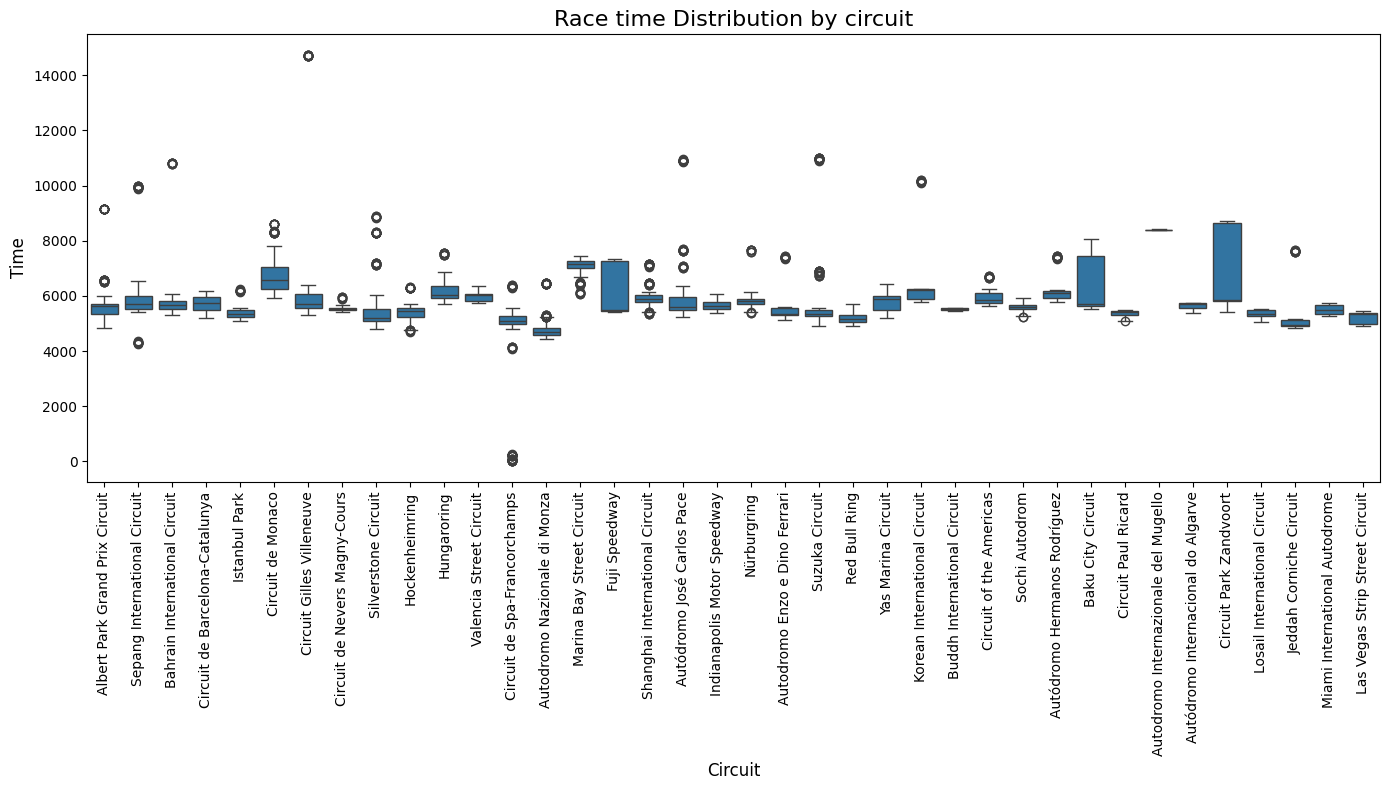

In [37]:
plt.figure(figsize=(14, 8))

ax = sns.boxplot(x='circuit_name', y='finishing_time', data=df_filtered)

plt.xticks(rotation=90)

plt.title('Race time Distribution by circuit', fontsize=16)
plt.xlabel('Circuit', fontsize=12)
plt.ylabel('Time', fontsize=12)

plt.tight_layout()

plt.show()

## Distribuzione dei Punti per Pilota (dal 2015)

Proseguiamo l'analisi a livello individuale, concentrandoci sulla distribuzione dei punti ottenuti da ciascun pilota. Per questa visualizzazione, abbiamo filtrato i dati per includere solo le stagioni a partire dal **2015** e abbiamo creato una colonna `driver_name` per facilitare l'identificazione 

Il box plot seguente mostra:
-   L'**asse X**: i nomi dei piloti che hanno partecipato ad almeno una gara dal 2015 in poi.
-   L'**asse Y**: i punti ottenuti da un pilota in una singola gara.

Da questo grafico possiamo dedurre:
-   **Performance di Punteggio Individuale**: La posizione e l'altezza della scatola per ciascun pilota indicano la sua capacità tipica di segnare punti e la relativa consistenza. Piloti con mediane più alte e scatole posizionate più in alto generalmente ottengono risultati migliori.
-   **Variabilità dei Risultati**: L'ampiezza della scatola (IQR) e dei baffi riflette la variabilità dei punteggi di un pilota.
-   **Risultati Eccezionali**: I punti isolati evidenziano gare specifiche in cui un pilota ha ottenuto un punteggio significativamente diverso dalla sua norma (ad esempio, vittorie, podi inattesi, o anche risultati a zero se la sua norma è segnare punti).

Questa analisi ci permette di confrontare le prestazioni dei singoli piloti nell'era più recente della Formula 1, evidenziando chi ha costantemente lottato per le posizioni di vertice e chi ha avuto performance più sporadiche in termini di punteggio.

/var/folders/mz/2x3r_7v12sl_hfwrgd4nzpm00000gn/T/ipykernel_72641/2290763182.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_2['driver_name'] = df_filtered_2['forename'] + ' ' + df_filtered_2['surname']


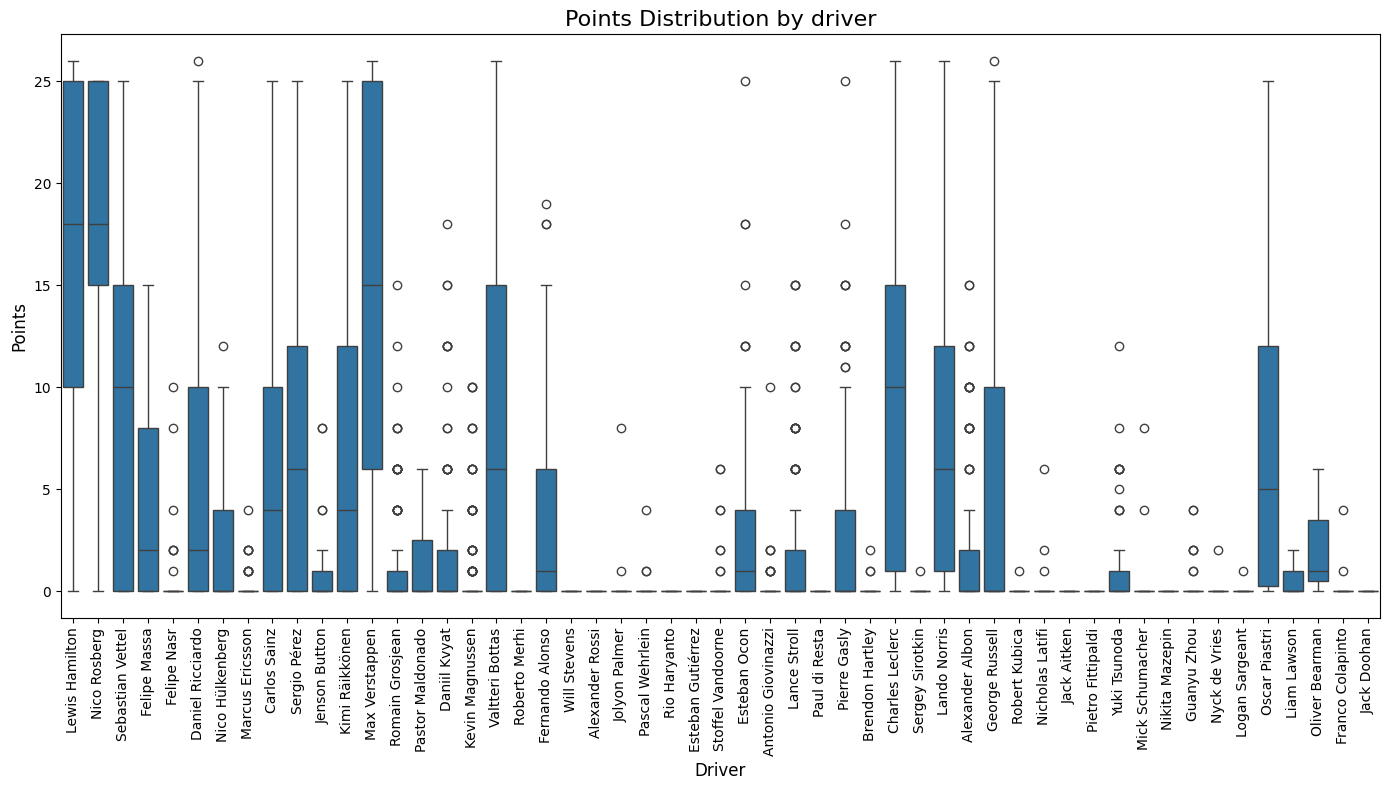

In [47]:
plt.figure(figsize=(14, 8))

df_filtered_2 = df.loc[df['year']>=2015]

df_filtered_2['driver_name'] = df_filtered_2['forename'] + ' ' + df_filtered_2['surname']

ax = sns.boxplot(x='driver_name', y='points', data=df_filtered_2)

plt.xticks(rotation=90)

plt.title('Points Distribution by driver', fontsize=16)
plt.xlabel('Driver', fontsize=12)
plt.ylabel('Points', fontsize=12)

plt.tight_layout()

plt.show()

<br>

---

## Esplorazione delle Relazioni tra Variabili Chiave tramite Matrice di Scatter Plot

Per comprendere meglio come diverse metriche numeriche interagiscono tra loro,  generiamo una matrice di scatter plot. Questa visualizzazione ci permette di osservare sia la distribuzione di ogni singola variabile (sulla diagonale) sia le relazioni a coppie tra di esse (fuori dalla diagonale). Le variabili incluse sono: `starting_position`, `points`, `laps`, `finishing_time`, `year`, e `round`.


[]

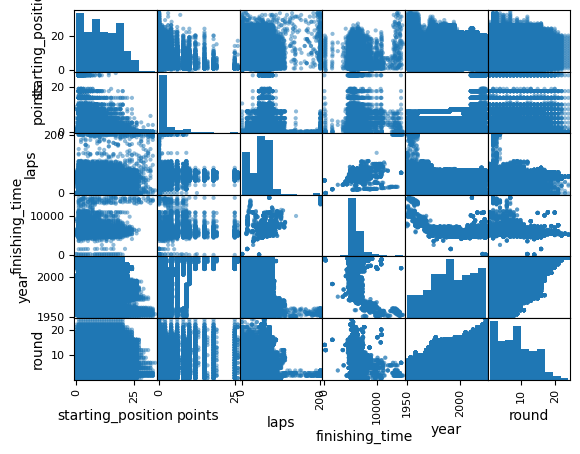

In [48]:
pd.plotting.scatter_matrix(df[['starting_position', 'points', 'laps','finishing_time',
       'year', 'round']])
plt.plot()

**Interpretazione della Matrice:**
-   I grafici sulla **diagonale principale** sono **istogrammi** che mostrano la forma della distribuzione di ciascuna variabile.
-   Tutti gli **altri grafici** sono **scatter plot**. Per un dato scatter plot, la variabile sull'**asse Y** è quella indicata dall'etichetta della sua riga, mentre la variabile sull'**asse X** è quella indicata dall'etichetta della sua colonna.

**Principali Osservazioni e Conclusioni:**

1.  **Importanza della Posizione di Partenza sui Punti (Grafico 7: Y=`points`, X=`starting_position`):**
    *   I punteggi più elevati sono quasi esclusivamente ottenuti partendo dalle primissime posizioni della griglia. Partire da posizioni più arretrate è fortemente associato a 0 punti.
    *   *Conclusione:* La posizione di partenza è un fattore determinante per il potenziale di punteggio in una gara.

2.  **Ruolo dei Giri Completati (Grafico 14: Y=`laps`, X=`points`):**
    *   Per ottenere punti (Grafico 14), è necessario completare un numero elevato di giri. I ritiri precoci (pochi giri) portano a 0 punti.
    *   *Conclusione:* Arrivare alla fine della gara (o quasi) è una precondizione per segnare punti.

3.  **Tempo di Gara e Punti (Grafico 20: Y=`finishing_time`, X=`points`):**
    *   Tra i piloti che completano la gara (escludendo i tempi vicini a zero per i ritirati), tempi di gara inferiori (essere più veloci) tendono a corrispondere a un maggior numero di punti.
    *   *Conclusione:* La velocità, tradotta in un minor tempo di gara, è associata a migliori piazzamenti a punti.

4.  **Natura della Distribuzione dei Punti (Grafico 8: Istogramma di `points`):**
    *   La distribuzione dei punti è massicciamente sbilanciata verso lo zero, confermando che la maggior parte dei risultati individuali in una gara non porta all'assegnazione di punti.
    *   *Conclusione:* I punti in Formula 1 sono una risorsa scarsa, concentrata sui migliori classificati.


In sintesi, questa matrice di scatter plot conferma visivamente alcune dinamiche fondamentali della Formula 1: l'importanza cruciale della qualifica (posizione di partenza), la necessità di affidabilità (completare i giri) e la performance pura (tempo di gara) per ottenere punti, in un contesto dove la maggior parte dei partecipanti non segna.

---

<br>

## Quantificazione delle Relazioni: Heatmap della Matrice di Correlazione di Spearman

Per quantificare la forza e la direzione delle associazioni tra le nostre variabili numeriche, abbiamo calcolato la matrice di correlazione di Spearman e l'abbiamo visualizzata come una heatmap. Il coefficiente di correlazione di Spearman varia da -1 (correlazione negativa perfetta) a +1 (correlazione positiva perfetta), con 0 che indica nessuna correlazione monotona. I valori numerici sono annotati su ciascuna cella, e i colori (dal viola/blu scuro per correlazioni negative/deboli al giallo per correlazioni positive forti) aiutano nell'interpretazione visiva.

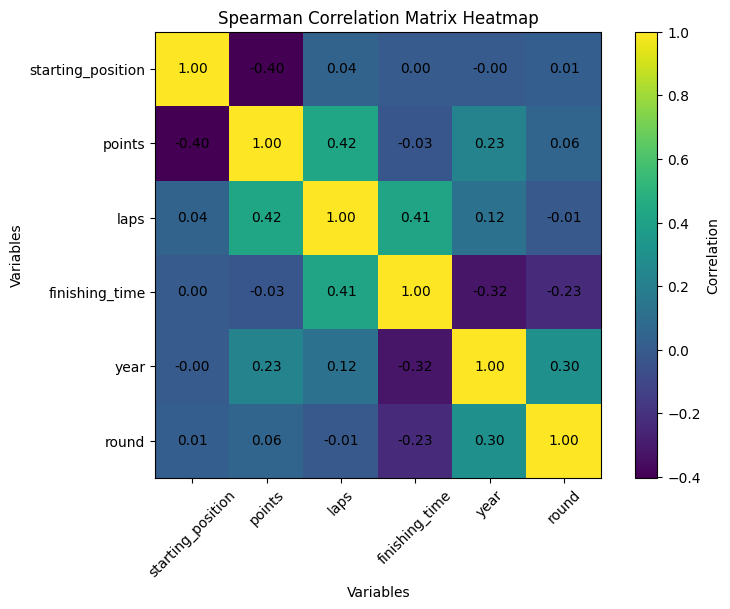

In [50]:
corr_spearman=df[['starting_position', 'points', 'laps','finishing_time',
       'year', 'round']].corr(method='spearman')

## Plot correlation using a heatmap

plt.figure(figsize=(8, 6))
plt.imshow(corr_spearman, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Spearman Correlation Matrix Heatmap')
# Annotate cells with correlation values
for i in range(len(corr_spearman)):
    for j in range(len(corr_spearman)):
        plt.text(j, i, f"{corr_spearman.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.xticks(ticks=np.arange(len(corr_spearman.columns)), labels=corr_spearman.columns, rotation=45)
plt.yticks(ticks=np.arange(len(corr_spearman.columns)), labels=corr_spearman.columns)
plt.tight_layout()
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()



**Principali Risultati della Correlazione:**

1.  **Posizione di Partenza vs. Punti (`starting_position` & `points`):**
    *   Coefficiente: **-0.40**. Indica una **correlazione negativa moderata**. Conferma che partire da posizioni più avanzate è associato a un maggior numero di punti.

2.  **Giri Completati vs. Punti (`laps` & `points`):**
    *   Coefficiente: **0.42**. Mostra una **correlazione positiva moderata**. Più giri vengono completati, maggiore è la tendenza a ottenere punti.

3.  **Giri Completati vs. Tempo di Gara (`laps` & `finishing_time`):**
    *   Coefficiente: **0.41**. Rivela una **correlazione positiva moderata** (più giri, più tempo).

4.  **Anno vs. Tempo di Gara (`year` & `finishing_time`):**
    *   Coefficiente: **-0.32**. Suggerisce una **correlazione negativa moderata**, indicando che i tempi di gara tendono a diminuire negli anni più recenti, probabilmente a causa dell'evoluzione tecnologica e dell'aumento della velocità delle vetture.

5.  **Anno vs. Punti (`year` & `points`):**
    *   Coefficiente: **0.23**. Una **correlazione positiva debole**, che potrebbe suggerire una leggera tendenza a ottenere più punti per singolo risultato di gara negli anni più recenti, a causa di modifiche minori nei sistemi di punteggio o un aumento del numero di gare che assegnano punti (es. sprint).

6.  **Correlazioni Vicine a Zero:**
    *   Molte altre coppie mostrano coefficienti molto vicini a zero (es. `starting_position` e `laps` (0.04), `starting_position` e `finishing_time` (0.00), `points` e `finishing_time` (-0.03)). Questo indica una relazione molto debole o assente tra queste coppie di variabili (che valutiamo come **indipendenti**).  
    Per `points` e `finishing_time`, la scatter matrix suggeriva una relazione per chi finiva, ma l'aggregazione generale qui, includendo i ritiri con `finishing_time` a 0, annulla questa correlazione.

Questa heatmap fornisce una misura numerica concisa delle dipendenze, supportando le osservazioni qualitative fatte con la matrice di scatter plot e offrendo una base più solida per comprendere quali fattori sono più fortemente associati tra loro nel contesto dei risultati delle gare di Formula 1.

---

<br>

## Analisi della Distribuzione delle Variabili Numeriche Chiave tramite Istogrammi

Per esaminare più da vicino la distribuzione di ciascuna delle nostre principali variabili numeriche, abbiamo generato una serie di istogrammi. Ogni istogramma mostra la frequenza con cui i valori di una variabile cadono all'interno di specifici intervalli (bin). Le variabili analizzate sono: `starting_position`, `points`, `laps`, `finishing_time`, `year`, e `round`.

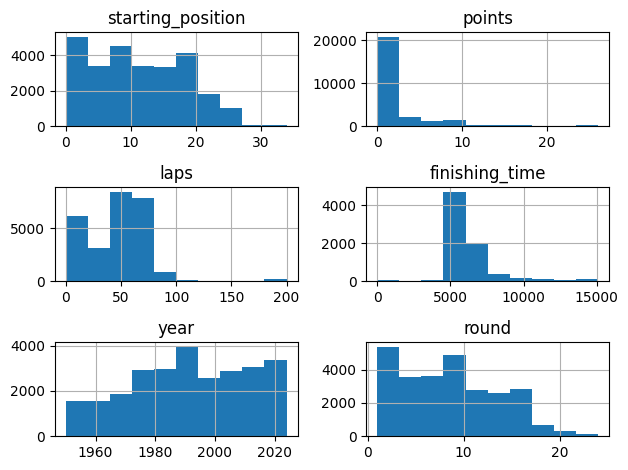

In [53]:
df[num_columns].hist()
plt.tight_layout()
plt.show()

**Principali Osservazioni dalle Distribuzioni Individuali:**

1.  **`starting_position` (Posizione di Partenza):**
    *   La distribuzione mostra frequenze elevate per le prime posizioni della griglia, un calo per le posizioni intermedie e un successivo aumento per le posizioni più arretrate. Questo riflette la composizione tipica di una griglia di partenza, incluse le partenze dal fondo per varie ragioni (penalità).

2.  **`points` (Punti Ottenuti):**
    *   Questa variabile è caratterizzata da una distribuzione estremamente asimmetrica, con la stragrande maggioranza dei risultati di gara individuali che ottengono **zero punti**. Ciò evidenzia la natura competitiva e selettiva del sistema di punteggio della Formula 1.

3.  **`laps` (Giri Completati):**
    *   Si osserva un picco pronunciato a un numero elevato di giri, indicando che una grande proporzione di partecipanti completa l'intera distanza di gara. Sono presenti anche frequenze significative per numeri inferiori di giri, rappresentative dei ritiri avvenuti a diversi stadi della competizione, incluso un picco per ritiri molto precoci.

4.  **`finishing_time` (Tempo di Gara):**
    *   La distribuzione mostra un raggruppamento principale attorno ai tempi di gara tipici per le corse completate (generalmente tra 1.5 e 2 ore). È presente anche una piccola barra a valori di tempo prossimi allo zero, attribuibile ai ritiri per i quali il tempo di completamento non è significativo o è registrato come tale.

5.  **`year` (Anno della Gara):**
    *   L'istogramma dell'anno illustra la distribuzione temporale dei dati nel nostro dataset, mostrando quali periodi storici della Formula 1 contribuiscono con un maggior numero di osservazioni (risultati pilota-gara).

6.  **`round` (Numero della Gara nella Stagione):**
    *   Questo istogramma mostra come i dati sono distribuiti attraverso i vari round di una stagione di campionato.

Questi istogrammi forniscono una comprensione fondamentale della forma e delle caratteristiche di ciascuna variabile numerica, che è essenziale prima di procedere con analisi più complesse o modellazione. Le forti asimmetrie e le peculiarità osservate (come la dominanza dello zero nei punti) sono aspetti da considerare.

---

<br>

## Trasformazione e Scalatura delle Variabili Numeriche

Per preparare i nostri dati a possibili analisi modellistiche e per migliorare alcune proprietà distributive, abbiamo applicato due trasformazioni sequenziali a un sottoinsieme selezionato di variabili numeriche: `starting_position`, `points`, `laps`, `year`, e `round`. La variabile `finishing_time` è stata esclusa da questo passaggio. L'obiettivo è gestire l'asimmetria, stabilizzare la varianza e scalare i dati.

### 1. Trasformazione di Box-Cox

La prima trasformazione applicata è la **Box-Cox**. Questa trasformazione di potenza mira a rendere la distribuzione di ciascuna variabile più simmetrica e simile a una distribuzione normale (gaussiana). È particolarmente utile per variabili con distribuzioni asimmetriche.

**Processo:**
- Per ogni colonna selezionata, abbiamo prima gestito eventuali valori non positivi aggiungendo un piccolo shift (pari a `-valore_minimo + epsilon`) per assicurare che tutti i dati fossero positivi, un requisito della trasformazione Box-Cox.
- Successivamente, è stata applicata la trasformazione `stats.boxcox`. Questa funzione determina automaticamente il parametro ottimale `lambda` ($\lambda$) per ciascuna colonna, che definisce la specifica trasformazione di potenza utilizzata. I valori di lambda trovati sono stati memorizzati.
- Infine, abbiamo visualizzato gli istogrammi delle variabili dopo questa trasformazione.


### 2. Scalatura con RobustScaler

Dopo la trasformazione di Box-Cox, abbiamo applicato uno **RobustScaler** alle stesse variabili. RobustScaler è un metodo di scalatura che rimuove la mediana e scala i dati in base all'intervallo interquartile (IQR). È "robusto" perché meno sensibile agli outlier rispetto ad altri metodi di scalatura come StandardScaler (che usa media e deviazione standard).

**Processo:**
- È stato inizializzato un `RobustScaler`.
- Il metodo `fit_transform` dello scaler è stato applicato alle colonne precedentemente trasformate con Box-Cox.
- Sono stati visualizzati gli istogrammi delle variabili dopo questa seconda trasformazione.


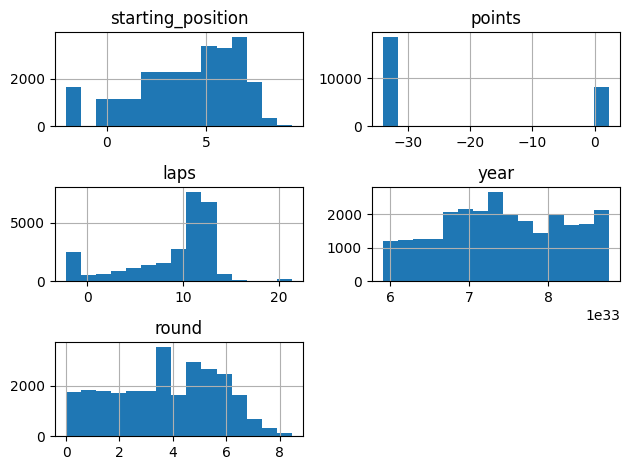

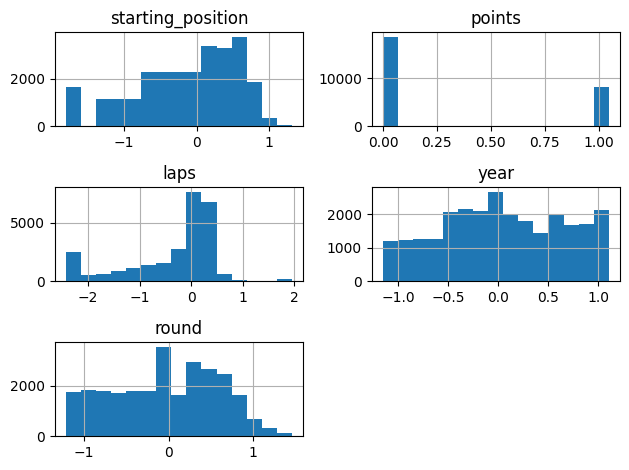

In [54]:
num_columns_2 = ["starting_position", "points", "laps", "year", "round"]

transformed_df = df[num_columns_2].copy()
lambda_dict={}
# Apply Box-Cox transformation
for col in num_columns_2:
    # Perform Box-Cox transformation
    min_val = transformed_df[col].min()
    if min_val<=0:
        shift=-min_val+1e-4
    else:
        shift=0
    new_values, lambda_val = stats.boxcox(transformed_df[col]+shift)

    lambda_dict[col]=lambda_val
    transformed_df[col] = new_values

transformed_df.hist(bins=15)
plt.tight_layout()
plt.show()

print("\n")

# Apply RobustScaler transformation
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
transformed_real_cov = pd.DataFrame(scaler.fit_transform(transformed_df[num_columns_2]))
transformed_real_cov.columns=num_columns_2

transformed_real_cov.hist(bins=15)
plt.tight_layout()
plt.show()

**Osservazioni sugli Istogrammi dopo la Trasformazione di Box-Cox (Primo Set di Grafici):**

*   **`starting_position`:** La distribuzione appare leggermente più compattata e potenzialmente un po' più simmetrica rispetto all'originale.

<br>

*   **`points`:** Questa variabile rimane fortemente problematica. A causa dell'altissima frequenza di zeri (piloti che non ottengono punti), la trasformazione Box-Cox (anche con lo shift) fatica a normalizzarla. L'istogramma mostra ancora un picco estremo. Questo indica che la trasformazione non ha risolto l'asimmetria fondamentale dovuta alla natura dei dati di punteggio. *Nota: l'asse X va da circa -35 a 0, suggerendo che i valori trasformati sono in gran parte negativi; questo può accadere a seconda del lambda scelto e dello shift.*

<br>

*   **`laps`:** La distribuzione dei giri completati sembra beneficiare della trasformazione, apparendo più simmetrica e con una forma che si avvicina di più a una campana rispetto alla distribuzione originale che aveva picchi distinti per ritiri e fine gara.

<br>

*   **`year`:** L'istogramma dell'anno mostra una forma che potrebbe essere leggermente cambiata, ma la principale osservazione dal grafico fornito suggerisce che la trasformazione di Box-Cox applicata direttamente a valori grandi come gli anni (es. 1950-2020) può portare a valori trasformati su una scala numerica problematica o estremamente grande, a seconda del lambda.

*   **`round`:** Anche la distribuzione del round della gara sembra essere diventata un po' più simmetrica e centrata.

<br>

**Osservazioni sugli Istogrammi dopo RobustScaler (Secondo Set di Grafici):**

*   **Impatto Generale:** RobustScaler centra i dati (la mediana della nuova distribuzione sarà vicina a 0) e li scala. La *forma* della distribuzione ottenuta dopo Box-Cox viene per lo più preservata, ma la scala sull'asse X è ora significativamente diversa, tipicamente con la maggior parte dei dati che cade in un intervallo più ristretto (a seconda dell'IQR originale).
*   **`starting_position`:** La distribuzione, già modificata da Box-Cox, è ora centrata e scalata.
*   **`points`:** La distribuzione rimane dominata dal picco che rappresenta gli zero punti originali. RobustScaler non cambia la forma intrinseca dell'asimmetria, ma scala i valori.
*   **`laps`:** La distribuzione, resa più simmetrica da Box-Cox, è ora centrata attorno a zero e scalata.
*   **`year`:** La distribuzione è ora centrata e scalata. Se c'erano problemi di scala estrema dopo Box-Cox (come visto per la variabile 'year'), RobustScaler riporta i valori in un range più maneggevole, concentrandoli attorno alla mediana trasformata.
*   **`round`:** Similmente alle altre, la distribuzione è ora centrata e scalata, mantenendo la forma post-Box-Cox.

<br>

**Conclusioni Complessive sulle Trasformazioni:**

La trasformazione di Box-Cox ha tentato di normalizzare le distribuzioni, con successo variabile a seconda della natura originale della variabile (es. efficace per `laps`, meno per `points`). Ha anche evidenziato la sensibilità a variabili con scale grandi come `year`. RobustScaler ha poi standardizzato le scale di queste variabili trasformate, rendendole più comparabili.  
La particolarità della variabile `points` (dominanza degli zeri) rimane problematica per le tecniche di normalizzazione standard.

---

<br>

## Analisi di Clustering con DBSCAN e Determinazione dei Parametri

Dopo la preparazione e la scalatura delle feature numeriche (`starting_position`, `points`, `laps`, `year`, `round`), applichiamo l'algoritmo di clustering DBSCAN per identificare gruppi basati sulla densità e rilevare eventuali outlier nei dati.

In [60]:
def plot_pca(df, n_components=2, figsize=(10, 8), random_state=42, c='k'):

    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    pca = PCA(n_components=n_components, random_state=random_state)
    principal_components = pca.fit_transform(numeric_df)

    # Create a DataFrame with the principal components
    pc_df = pd.DataFrame(
        data=principal_components,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_ * 100

    # Create the plot
    plt.figure(figsize=figsize)

    # Scatter plot of the first two PCs
    if n_components >= 2:
        sns.scatterplot(x='PC1', y='PC2', data=pc_df, c=c)

        plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
        plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
        plt.title('PCA of Rescaled Features')

        # Add a tight grid
        plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print explained variance information
    print(f'Total explained variance: {sum(explained_variance):.2f}%')
    for i, variance in enumerate(explained_variance):
        print(f'PC{i+1}: {variance:.2f}%')

    return pca, pc_df

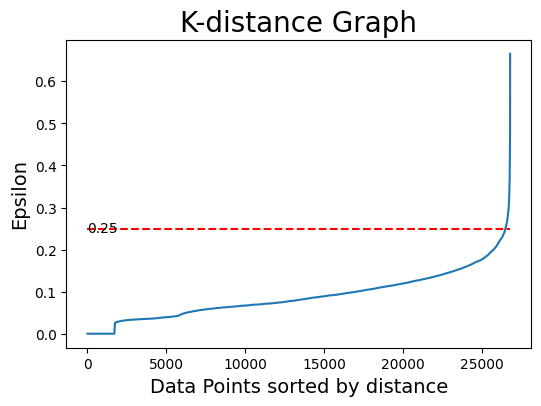

Value Counts:
-1: 2870
0: 337
1: 646
2: 10
3: 6974
4: 12908
5: 580
6: 11
7: 10
8: 6
9: 6
10: 1449
11: 5
12: 10
13: 11
14: 16
15: 13
16: 21
17: 59
18: 20
19: 16
20: 18
21: 119
22: 10
23: 93
24: 79
25: 12
26: 8
27: 43
28: 21
29: 10
30: 30
31: 148
32: 22
33: 11
34: 31
35: 13
36: 18
37: 9
38: 9
39: 12
40: 9
41: 13
42: 5
43: 10
44: 13
45: 15


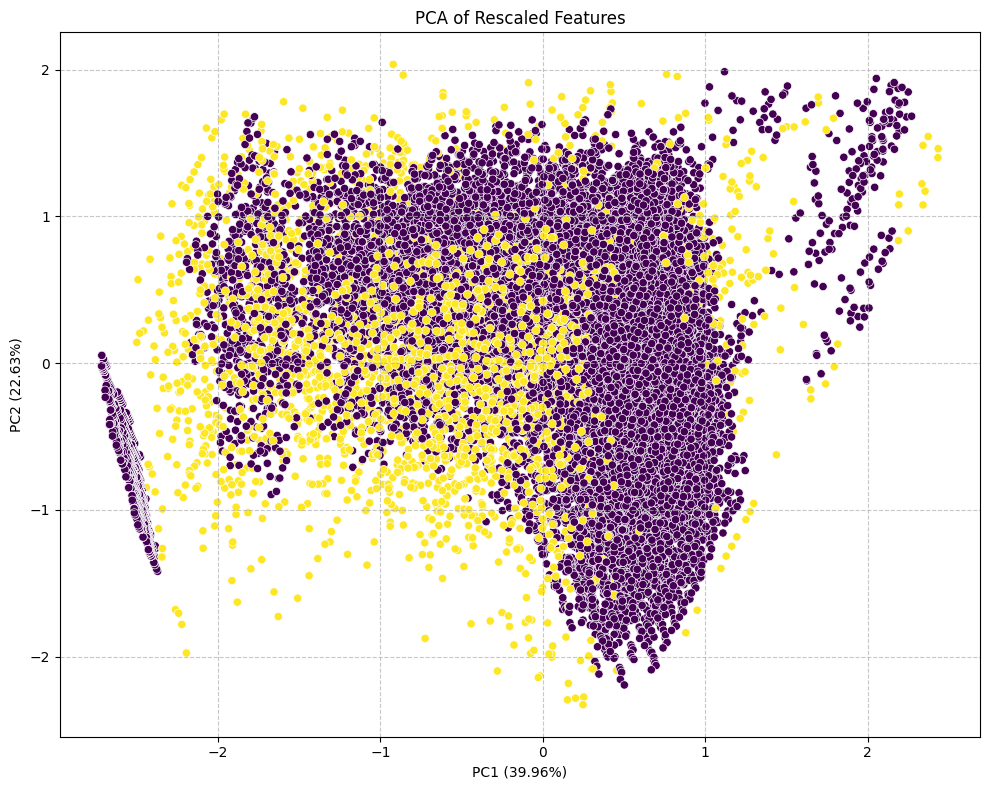

Total explained variance: 62.58%
PC1: 39.96%
PC2: 22.63%


In [74]:
neigh = NearestNeighbors(n_neighbors=2)
# addestra l'oggetto per trovare rapidamente i vicini 
nbrs = neigh.fit(transformed_real_cov)


# per ogni punto nel df trasformato calcola:
# distances -> matrice dove ogni riga i contiene le distsanza dal punto i ai suoi n vicini più prossimi
# indices   -> matrice con indici di questi vicini 
distances, indices = nbrs.kneighbors(transformed_real_cov)

# ordina distanze 
distances = np.sort(distances, axis=0)
# prendiamo colonna giusta TODO
distances = distances[:,-1]
plt.figure(figsize=(6,4))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14,color='k')
plt.hlines(0.25, xmin=0, xmax=len(distances), colors='r', linestyles='dashed')  
plt.text(0, 0.25, '0.25', ha ='left', va ='center')
plt.show()


# --- DBSCAN ---

# numero minimo di punti (considerando se stesso) che devono trovarsi nel raggio eps per essere core points
min_samples=2*len(num_columns_2)
eps=0.25
model = DBSCAN(eps = eps, min_samples = min_samples).fit(transformed_real_cov)
labels = model.labels_
outliers_DBSCAN=(labels==-1).astype(int)


# Get unique values and their counts
unique_values, counts = np.unique(labels, return_counts=True)

# Create a dictionary to store the counts of each value
value_counts = dict(zip(unique_values, counts))

# Print the value counts
print("Value Counts:")
for value, count in value_counts.items():
    print(f"{value}: {count}")


plot_pca(transformed_real_cov, n_components=2, figsize=(10, 8), random_state=42, c=outliers_DBSCAN)
plt.show()

### Risultati del Clustering DBSCAN

Applicando DBSCAN al dataset trasformato (`transformed_real_cov`) con `eps = 0.25` e `min_samples = 10`, abbiamo ottenuto la seguente distribuzione di etichette di cluster e outlier:

*   **Conteggio delle Etichette:**
    ```
    -1: 2870  (Punti etichettati come Outlier/Rumore)
     0: 337
     1: 646
     2: 10
     3: 6974
     4: 12908 (Cluster più numeroso)
     ... (seguito da numerosi altri cluster più piccoli, per un totale di 46 cluster distinti oltre al rumore)
    ```
    Questi risultati indicano che DBSCAN ha identificato un numero significativo di outlier (2870 punti) e ha raggruppato i restanti punti in 46 cluster di varie dimensioni. I cluster 3 e 4 sono i più popolati.

### Visualizzazione dei Risultati tramite PCA

Per visualizzare i risultati del clustering in uno spazio a dimensionalità ridotta, abbiamo applicato la Principal Component Analysis (PCA) al dataset `transformed_real_cov`, riducendolo a 2 componenti principali. I punti nel grafico PCA sono stati colorati in base alla loro etichetta DBSCAN: i punti appartenenti a un cluster sono visualizzati in viola, mentre gli outlier (etichetta -1) sono in giallo.

*   **Grafico PCA dei Risultati DBSCAN:**
    Il grafico PCA mostra:
    *   Le prime due componenti principali (PC1 e PC2) spiegano rispettivamente il 39.96% e il 22.63% della varianza (totale ~62.59%).
    *   I punti gialli (outlier identificati da DBSCAN) tendono a localizzarsi nelle regioni periferiche o più sparse della distribuzione dei dati proiettata.
    *   I punti viola (membri dei cluster) formano aggregazioni più dense. È importante notare che, a causa della proiezione da uno spazio a 5 dimensioni a uno a 2 dimensioni, alcuni outlier (gialli) potrebbero apparire visivamente vicini a gruppi di punti clusterizzati (viola); tuttavia, la loro classificazione come outlier è basata sulle loro relazioni di densità nello spazio originale a 5 dimensioni.

Questa analisi suggerisce che i nostri dati contengono una struttura clusterizzabile significativa, così come un numero non trascurabile di punti che si discostano dai pattern di densità principali.

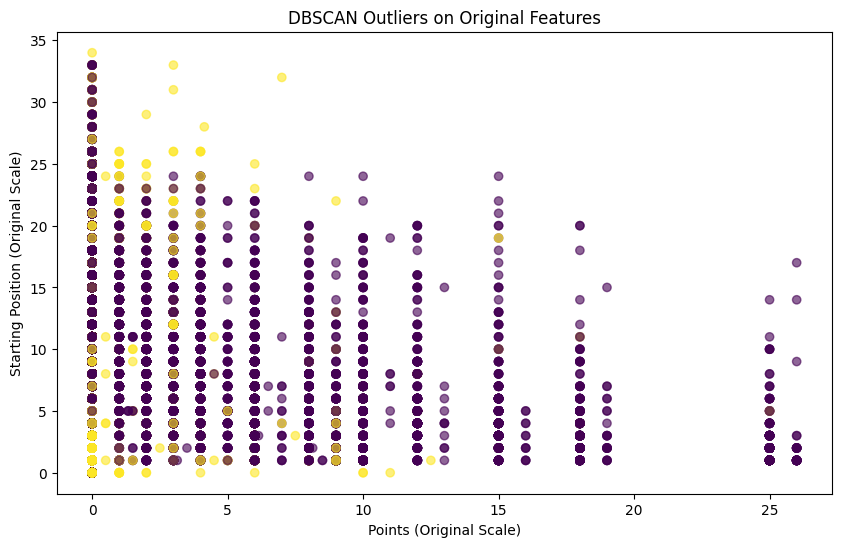

In [75]:
plt.figure(figsize=(10, 6))
scatter_data = df.loc[transformed_real_cov.index] 
plt.scatter(scatter_data['points'], scatter_data['starting_position'], c=outliers_DBSCAN, alpha=0.6)
plt.xlabel('Points (Original Scale)')
plt.ylabel('Starting Position (Original Scale)')
plt.title('DBSCAN Outliers on Original Features')
plt.show()

---

<br>

### Rilevamento degli Outlier con Local Outlier Factor (LOF)

Per un approccio alternativo al rilevamento degli outlier, abbiamo utilizzato l'algoritmo Local Outlier Factor (LOF). LOF valuta l'anomalia di un punto misurando la deviazione della sua densità locale rispetto a quella dei suoi vicini.






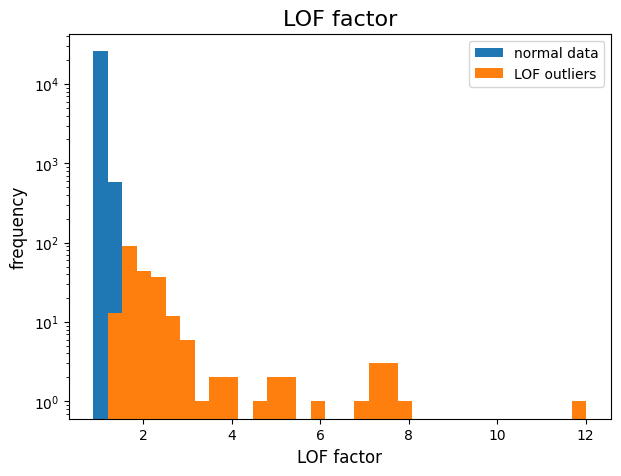

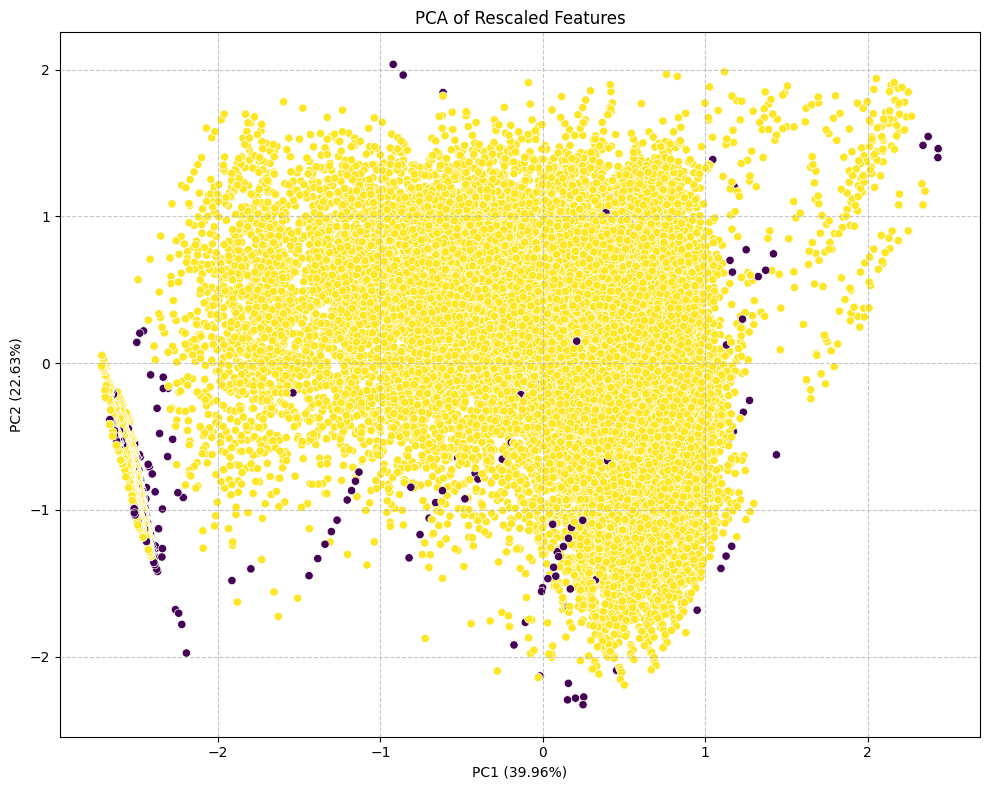

Total explained variance: 62.58%
PC1: 39.96%
PC2: 22.63%
223


In [86]:
lof = LocalOutlierFactor(novelty=False,contamination='auto')
labels = lof.fit_predict(transformed_real_cov)


lof_scores=-lof.negative_outlier_factor_
plt.figure(figsize=(7,5))
plt.hist(lof_scores[labels>-1],bins=np.linspace(min(lof_scores), max(lof_scores), 35),label='normal data')
plt.hist(lof_scores[labels==-1],bins=np.linspace(min(lof_scores), max(lof_scores), 35),label='LOF outliers')
plt.xlabel('LOF factor',fontsize=12)
plt.ylabel('frequency',fontsize=12)
plt.title('LOF factor',fontsize=16)
plt.legend()
plt.yscale('log')
plt.show()



plot_pca(transformed_real_cov, n_components=2, figsize=(10, 8), random_state=42, c=labels)
plt.show()

print((labels==-1).sum())


**Risultati di LOF:**
*   Con i parametri specificati, LOF ha identificato **213 outlier** nel dataset. Un test con `contamination='auto'` ha prodotto un numero simile di outlier (223).


**Analisi dell'Istogramma dei LOF Factor:**
*   **Istogramma dei LOF Factor:**
    L'istogramma dei punteggi LOF mostra una chiara distinzione tra i dati considerati normali e gli outlier. La maggior parte dei dati normali presenta un LOF factor vicino a 1, indicando una densità locale simile a quella dei vicini. Gli outlier identificati, invece, mostrano punteggi LOF significativamente più elevati (distribuiti principalmente tra 2 e 12), confermando la loro minore densità locale rispetto all'intorno.

**Visualizzazione degli Outlier LOF tramite PCA:**
*   **Grafico PCA dei Risultati LOF:**
    La proiezione PCA (che spiega il 62.58% della varianza con le prime due componenti) visualizza i 213 outlier LOF (punti viola/scuri) rispetto agli inlier (punti gialli).
    *   Gli outlier LOF appaiono sparsi, con molti localizzati ai margini della distribuzione principale dei dati.
    

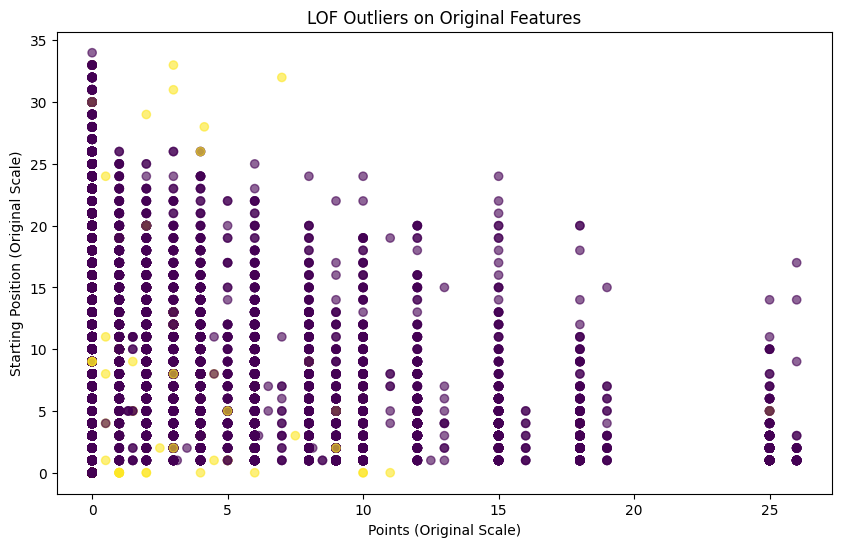

In [85]:
plt.figure(figsize=(10, 6))
scatter_data = df.loc[transformed_real_cov.index] 
outliers_LOF = (labels == -1) 
plt.scatter(scatter_data['points'], scatter_data['starting_position'], c=outliers_LOF, alpha=0.6, cmap='viridis') # cmap può aiutare a distinguere
plt.xlabel('Points (Original Scale)')
plt.ylabel('Starting Position (Original Scale)')
plt.title('LOF Outliers on Original Features')
plt.show()

## Confronto dei Metodi di Rilevamento Outlier e Scelta Finale

Abbiamo esplorato due approcci per l'identificazione degli outlier nel nostro dataset trasformato: DBSCAN e Local Outlier Factor (LOF).

**Riassunto dei Risultati:**
*   **DBSCAN** (con `eps=0.25`, `min_samples=10`): Ha identificato **2870 outlier** (circa il 10.7% del dataset). Questi punti non appartenevano a nessun cluster sufficientemente denso secondo i parametri definiti. La visualizzazione su coppie di feature originali (es. "Points" vs "Starting Position") ha mostrato che molti di questi outlier corrispondevano a risultati con 0 punti o pochi punti, distribuiti su varie posizioni di partenza.
*   **Local Outlier Factor (LOF)** (con `contamination=0.008`, `n_neighbors=20`): Ha identificato **213 outlier** (circa lo 0.8% del dataset). Questi sono punti con una densità locale significativamente inferiore a quella dei loro vicini. La visualizzazione su "Points" vs "Starting Position" ha mostrato che questi outlier LOF tendono ad essere un sottoinsieme più ristretto e potenzialmente più "estremo" rispetto a quelli identificati da DBSCAN.


Osservando questi grafici e i plot PCA precedenti, notiamo che DBSCAN adotta un approccio più "ampio" all'identificazione del rumore, mentre LOF (con la contaminazione specificata) è più mirato agli scostamenti locali di densità.

**Decisione:**
Considerando l'obiettivo di pulire il dataset da anomalie evidenti e preferendo un approccio inizialmente più conservativo alla rimozione dei dati, **scegliamo di procedere con gli outlier identificati da Local Outlier Factor (LOF)**. Questo ci permette di rimuovere un numero più contenuto di punti (213) che sono stati segnalati come particolarmente anomali in termini di densità locale, preservando la maggior parte del dataset per le fasi successive.


---

<br>

### Rimozione degli Outlier identificati da LOF

In [88]:
inliers_LOF_mask = (labels != -1)

df_no_outliers = df.loc[transformed_real_cov.index[inliers_LOF_mask]]

print(f"Numero originale di righe: {len(df)}")
print(f"Numero di outlier LOF identificati: {np.sum(labels == -1)}")
print(f"Numero di righe dopo la rimozione degli outlier LOF: {len(df_no_outliers)}")

Numero originale di righe: 26759
Numero di outlier LOF identificati: 223
Numero di righe dopo la rimozione degli outlier LOF: 26536
